# Dataset construction

In [1]:
import torch 
import numpy as np
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib.gridspec import GridSpec
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

np.random.seed(1328)
torch.random.manual_seed(1328)
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']


In [4]:

#FUNZIONE PER CARICARE IL DATASET DI IMMAGINI

def load_images_from_subfolders(main_folder):
    data = []
    label_names = {}
    label_index = 0    
    # Loop through each subject folder
    for subject_folder in os.listdir(main_folder):
        subject_path = os.path.join(main_folder, subject_folder)
        if os.path.isdir(subject_path):
            # Loop through each letter subfolder
            for letter_folder in os.listdir(subject_path):  # Correzione qui
                letter_path = os.path.join(subject_path, letter_folder)
                if os.path.isdir(letter_path):
                    # Get or create a label index for the letter
                    if letter_folder not in label_names:
                        label_names[letter_folder] = label_index
                        label_index += 1
                    label = label_names[letter_folder]
                    
                    # Load each image in the letter subfolder
                    for filename in os.listdir(letter_path):
                        img = cv2.imread(os.path.join(letter_path, filename), cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, (100, 100)) 
                            data.append({'image': img, 'label': label, 'letter': letter_folder, 'subject': subject_folder})
    
    return pd.DataFrame(data), label_names, class_names

def prepare_data(df):
    # Expand the dimensions of images to add the channel dimension
    df['image'] = df['image'].apply(lambda x: x[:, :, np.newaxis])
    
    # Convert labels to one-hot encoding
    labels = to_categorical(df['label'], num_classes=df['label'].nunique())
    df['label'] = list(labels)
    
    return df

#CREAZIONE TEST E TRAIN SET
def create_train_test_dataframe(df, test_size=0.2):
    # Split the dataset into training and testing sets
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=42, stratify=df['label'].apply(lambda x: np.argmax(x)))
    
    print(f"Train set: {df_train.shape}, Test set: {df_test.shape}")
    
    return df_train, df_test

#PLOT CLASS DISTRIBUITION
def plot_class_distribution(df, title, alphabet):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15, 6))
    label_indices = df['label'].apply(lambda x: np.argmax(x))  # Get the original class indices
    label_counts = label_indices.value_counts().reindex(range(len(alphabet)), fill_value=0)
    
    ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)
    ax.set_title(f"Distribution of Samples in {title} Data", fontsize=16, fontweight='bold')
    ax.set_xlabel("Class", fontsize=14)
    ax.set_ylabel("Number of Samples", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'plots/distribution_{title}_data.png')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
    plt.show()

#per plottare alcune immagini di esempio
def plot_sample_images(df_train, alphabet):
    fig = plt.figure(figsize=(9, 9))
    gs = GridSpec(3, 3, figure=fig)  # Griglia 3x3

    # Convert one-hot encoded labels back to integers for uniqueness
    df_train['label_int'] = df_train['label'].apply(lambda x: np.argmax(x))
    unique_labels = df_train['label_int'].unique()[:3]  # Limita a 3 categorie

    for i, category in enumerate(unique_labels):
        sample_images = df_train[df_train['label_int'] == category].sample(min(3, len(df_train[df_train['label_int'] == category])))
        for j, (index, row) in enumerate(sample_images.iterrows()):
            ax = fig.add_subplot(gs[i, j])
            img = row['image'].reshape(100, 100)  # Assuming the images are 64x64
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.text(0.5, -0.1, alphabet[category], fontsize=25, color='black', ha='center', transform=ax.transAxes)
    plt.show()

In [5]:
main_folder = 'dataset'
df, label_names, alphabet = load_images_from_subfolders(main_folder)
df = prepare_data(df)
df_train, df_test = create_train_test_dataframe(df)

Train set: (10596, 4), Test set: (2650, 4)


C:\Users\orazi\AppData\Local\Temp\ipykernel_24356\2206875324.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)


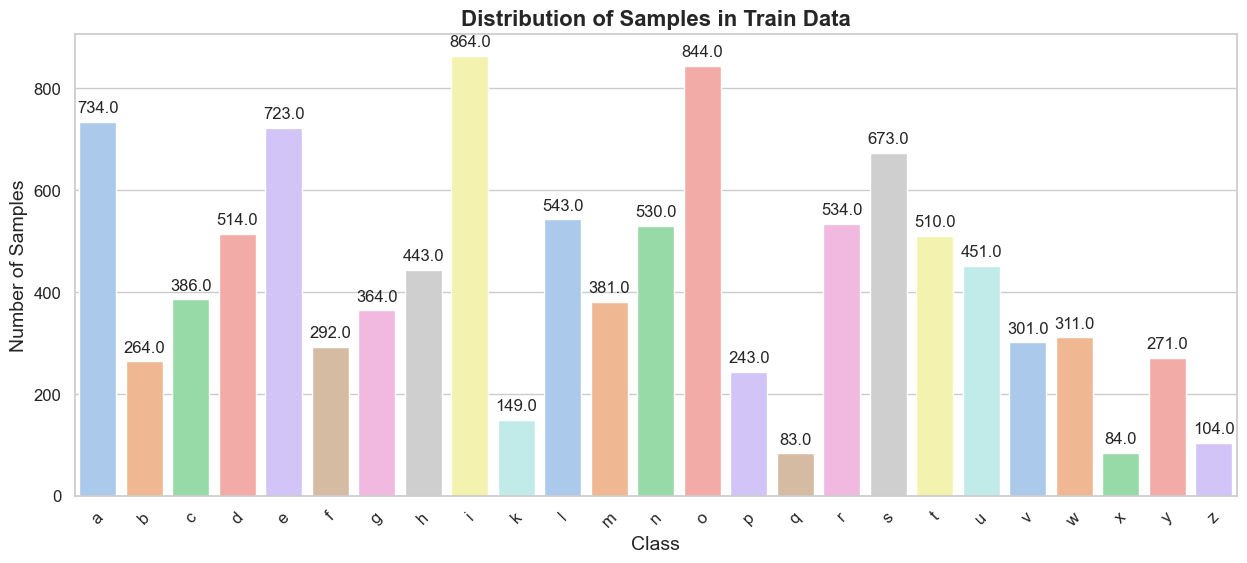

C:\Users\orazi\AppData\Local\Temp\ipykernel_24356\2206875324.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=alphabet, y=label_counts.values, palette="pastel", legend=False)


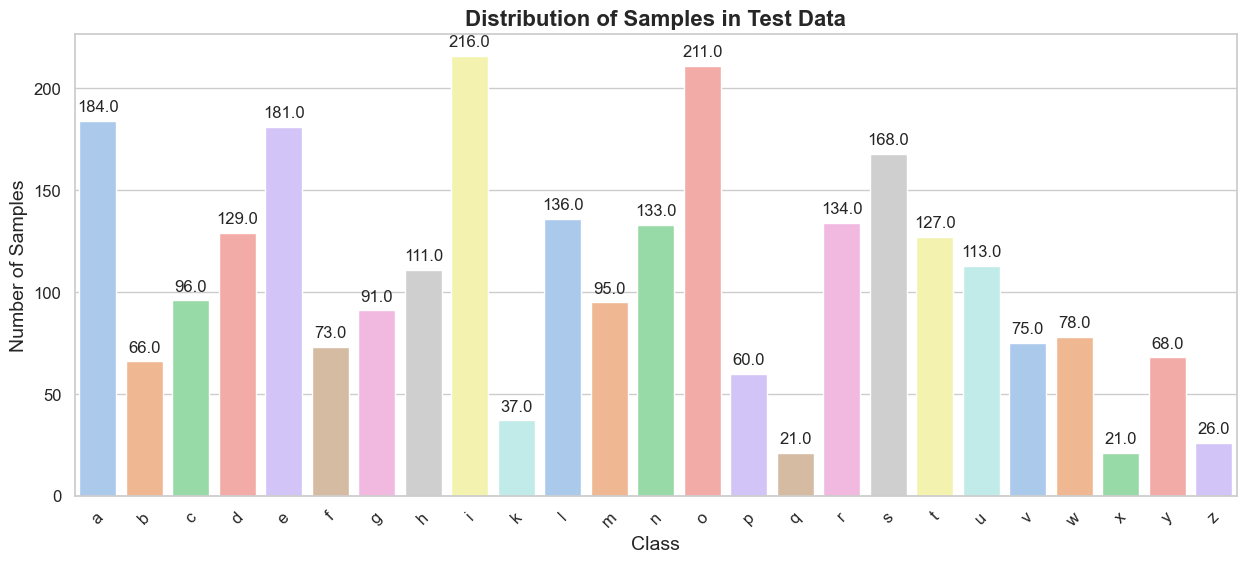

In [6]:
plot_class_distribution(df_train, 'Train', alphabet)
plot_class_distribution(df_test, 'Test', alphabet)

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(dataframe['label_int'].unique())}
        if self.augment:
            self.dataframe = pd.concat([dataframe, dataframe]).reset_index(drop=True)
        else:
            self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_array = row['image']
        if len(image_array.shape) == 3 and image_array.shape[2] == 1:
            image_array = image_array.squeeze(-1)  
        image = Image.fromarray(image_array.astype(np.uint8)).convert('RGB')  
        label = row['label_int']

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

df_train['label_int'] = df_train['label'].apply(lambda x: np.argmax(x))

# Split dataset into training, testing, and validation
train_df, test_val_df = train_test_split(df_train, test_size=0.4, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

train_dataset = CustomDataset(train_df, transform=train_transform, augment=True)
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [8]:
# Training data
print(f"Training Samples ({len(train_dataset)})")
inputs, classes = next(iter(train_loader))
print("Shape:", inputs.shape)

# Validation data
print(f"Validation Samples ({len(val_dataset)})")
inputs, classes = next(iter(val_loader))
print("Shape:", inputs.shape)

# Testing data
print(f"Testing Samples ({len(test_dataset)})")
inputs, classes = next(iter(test_loader))
print("Shape:", inputs.shape)

Training Samples (12714)
Shape: torch.Size([64, 3, 50, 50])
Validation Samples (2120)
Shape: torch.Size([64, 3, 50, 50])
Testing Samples (2119)
Shape: torch.Size([64, 3, 50, 50])


## Letter-Classifier model

In [9]:
class AverageValueMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.n = 0

    def add(self, value, n):
        self.sum += value * n
        self.n += n

    def value(self):
        return self.sum / self.n if self.n > 0 else 0

In [10]:

class LetterClassifier(nn.Module):
    
    def __init__(self, input_shape=(50, 50, 3), num_classes=25, dropout_rate=0.5):
        super(LetterClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # convolutional layer 1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # convolutional layer 2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # convolutional layer 3
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # convolutional layer 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512), # fully connected layer
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, num_classes) # output layer (fully connected)
        )

    def forward(self, x):
        return self.model(x)

    def numparams(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def train_model(self, train_loader, val_loader, exp_name='experiment', epochs=10, lr=0.001, momentum=0.9, weight_decay=1e-4, logdir='logs', verbose=True, save_model=True):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)  

        train_losses = []; train_accuracies = []
        val_losses = []; val_accuracies = []

        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        writer = SummaryWriter(join(logdir, exp_name))

        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") # usare cuda
        self.to(device)
        loader = {'train': train_loader, 'val': val_loader}

        global_step = 0
        best_val_loss = float('inf')
        epochs_no_improve = 0  
        patience = 10
        for e in range(epochs):
            print(f'[Epoch {e+1}/{epochs}]')
            for mode in ['train', 'val']:
                loss_meter.reset()
                acc_meter.reset()
                self.model.train() if mode == 'train' else self.model.eval()

                with torch.set_grad_enabled(mode == 'train'):
                    for i, batch in enumerate(loader[mode]):
                        X = batch[0].to(device)
                        y = batch[1].to(device)
                        out = self.model(X)

                        n = X.shape[0]
                        global_step += n
                        l = loss_fn(out, y)

                        if mode == 'train':
                            l.backward()
                            optimizer.step()
                            optimizer.zero_grad()

                        loss_meter.add(l.item(), n)
                        acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                        acc_meter.add(acc, n)

                        if mode == 'train':
                            writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                            writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)

                    writer.add_scalar('loss/'+mode, loss_meter.value(), global_step=global_step)
                    writer.add_scalar('accuracy/'+mode, acc_meter.value(), global_step=global_step)

                    if mode == 'train':
                        train_losses.append(loss_meter.value())
                        train_accuracies.append(acc_meter.value())
                    else:
                        val_losses.append(loss_meter.value())
                        val_accuracies.append(acc_meter.value())

                        if val_losses[-1] < best_val_loss:
                            best_val_loss = val_losses[-1]
                            epochs_no_improve = 0  
                            if save_model:
                                torch.save(self.model.state_dict(), os.path.join('models', f'{exp_name}.pth'))
                                with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
                                    pickle.dump({
                                        'train_loss': train_losses, 
                                        'val_loss': val_losses,
                                        'train_accuracy': train_accuracies, 
                                        'val_accuracy': val_accuracies
                                    }, f)
                        else:
                            epochs_no_improve += 1 

            if verbose:
                print(f'Train Loss: {train_losses[-1]:.3f}, Train Accuracy: {train_accuracies[-1]:.3f} | Val Loss: {val_losses[-1]:.3f}, Val Accuracy: {val_accuracies[-1]:.3f}\n')

            if epochs_no_improve == patience:
                print('Early stopping')
                break

        return train_losses, train_accuracies, val_losses, val_accuracies

    def test_model(self, test_loader):
        self.model.eval()
        loss_fn = nn.CrossEntropyLoss()
        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)

        with torch.no_grad():
            for batch in test_loader:
                X = batch[0].to(device)
                y = batch[1].to(device)
                out = self.model(X)

                n = X.shape[0]
                l = loss_fn(out, y)

                loss_meter.add(l.item(), n)
                acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                acc_meter.add(acc, n)

        test_loss = loss_meter.value()
        test_accuracy = acc_meter.value()

        return test_loss, test_accuracy

    def test_error(self, test_loader):
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.to(device)
        predictions, labels = [], []
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device)
                y = batch[1].to(device)
                output = self.model(x)
                preds = output.to('cpu').max(1)[1].numpy()
                labs = y.to('cpu').numpy()
                predictions.extend(list(preds))
                labels.extend(list(labs))
        error = (1 - accuracy_score(np.array(labels), np.array(predictions))) * 100
        return error
    
    def evaluate(self, test_loader):
        self.model.eval()
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())
        
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        
        return precision, recall, f1
    
    def confusion_matrix(self, test_loader):
        self.model.eval()
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())
        
        return confusion_matrix(all_labels, all_preds)
    
    def plot_precision_recall_curve(self, test_loader, file_path=None):
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.eval()
        self.to(device)
        
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        all_labels_bin = label_binarize(all_labels, classes=np.unique(all_labels))
        n_classes = all_labels_bin.shape[1]
        
        
        
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
            
            auc_score = auc(recall, precision)
            print(f'AUC per la classe {class_names[i]}: {auc_score:.3f}') 


In [11]:
letter_classifier = LetterClassifier()
print(f'The model has {letter_classifier.numparams()} trainable parameters')

The model has 1582361 trainable parameters


## Train the model

In [12]:
lr = 0.001
momentum = 0.9
weight_decay = 0.0001
dropout_rate = 0.2

exp_name = 'letter_classifier_2'
epochs = 200
'''
letter_classifier = LetterClassifier()


train_losses, train_accuracies, test_losses, test_accuracies = letter_classifier.train_model(train_loader,
                                                                                          val_loader,
                                                                                          exp_name=exp_name,
                                                                                          epochs=epochs,
                                                                                          lr=lr,
                                                                                          momentum=momentum,
                                                                                          weight_decay=weight_decay)

'''

'\nletter_classifier = LetterClassifier()\n\n\ntrain_losses, train_accuracies, test_losses, test_accuracies = letter_classifier.train_model(train_loader,\n                                                                                          val_loader,\n                                                                                          exp_name=exp_name,\n                                                                                          epochs=epochs,\n                                                                                          lr=lr,\n                                                                                          momentum=momentum,\n                                                                                          weight_decay=weight_decay)\n\n'

## Test the model

In [13]:
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
letter_classifier.model.load_state_dict(model_weights)
letter_classifier.model.eval()

with torch.no_grad():
    test_loss, test_accuracy = letter_classifier.test_model(test_loader)

print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

Test Loss: 0.879, Test Accuracy: 0.752


In [14]:
test_error = letter_classifier.test_error(test_loader)
print(f"Error percentage: {test_error:.2f} %")

Error percentage: 24.82 %


In [15]:
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

# Add the new metrics
metrics['test_loss'] = test_loss
metrics['test_accuracy'] = test_accuracy
metrics['test_error'] = test_error

# Save the updated metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

Metrics updated and saved successfully


## After model selection 

In [16]:
# Load the model
letter_classifier = LetterClassifier()
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
letter_classifier.model.load_state_dict(model_weights)
print("Model loaded successfully")

# Load metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

# Convert the metrics to float and round to 3 decimal places
train_losses = [round(float(i), 3) for i in metrics['train_loss']]
val_losses = [round(float(i), 3) for i in metrics['val_loss']]
train_accuracies = [round(float(i), 3) for i in metrics['train_accuracy']]
val_accuracies = [round(float(i), 3) for i in metrics['val_accuracy']]
test_loss = round(float(metrics['test_loss']), 3)
test_accuracy = round(float(metrics['test_accuracy']), 3)
test_error = round(float(metrics['test_error']), 2)

print(f"Best epoch: {len(val_losses)}/{epochs}\n")
print(f"Train Loss: {train_losses[-1]}")
print(f"Train Accuracy: {train_accuracies[-1]}\n")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Validation Accuracy: {val_accuracies[-1]}\n")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Error: {test_error}%")

Model loaded successfully
Metrics loaded successfully

Best epoch: 145/200

Train Loss: 1.864
Train Accuracy: 0.448

Validation Loss: 0.858
Validation Accuracy: 0.756

Test Loss: 0.879
Test Accuracy: 0.752
Test Error: 24.82%


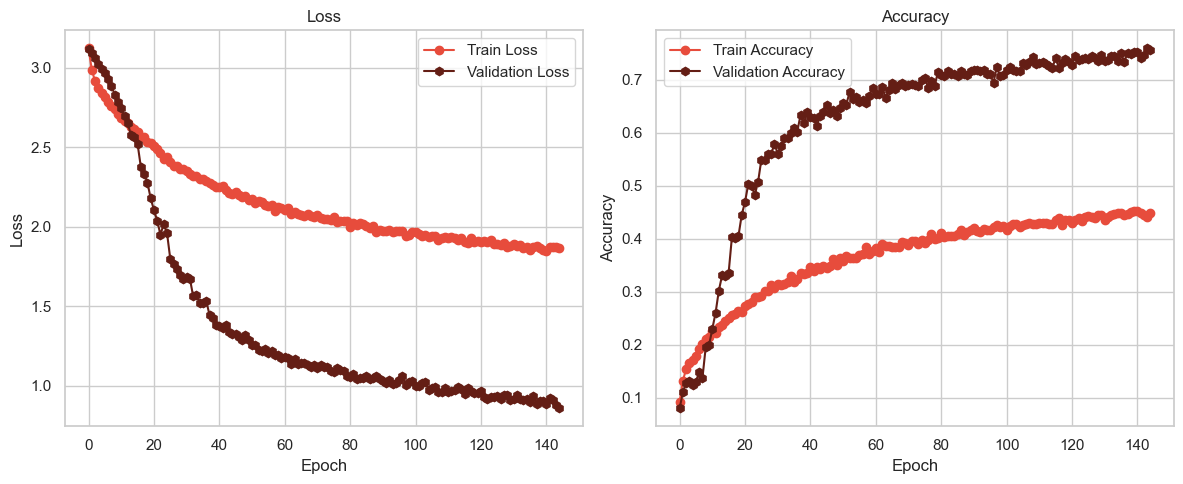

In [17]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color="#E74C3C", label='Train Loss', marker='o')
    plt.plot(val_losses, color="#641E15", label='Validation Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, color="#E74C3C", label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, color="#641E15", label='Validation Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, f'plots/{exp_name}_accuracy_and_Loss.png')

In [18]:
precision, recall, f1 = letter_classifier.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.759
Recall: 0.678
F1 Score: 0.690


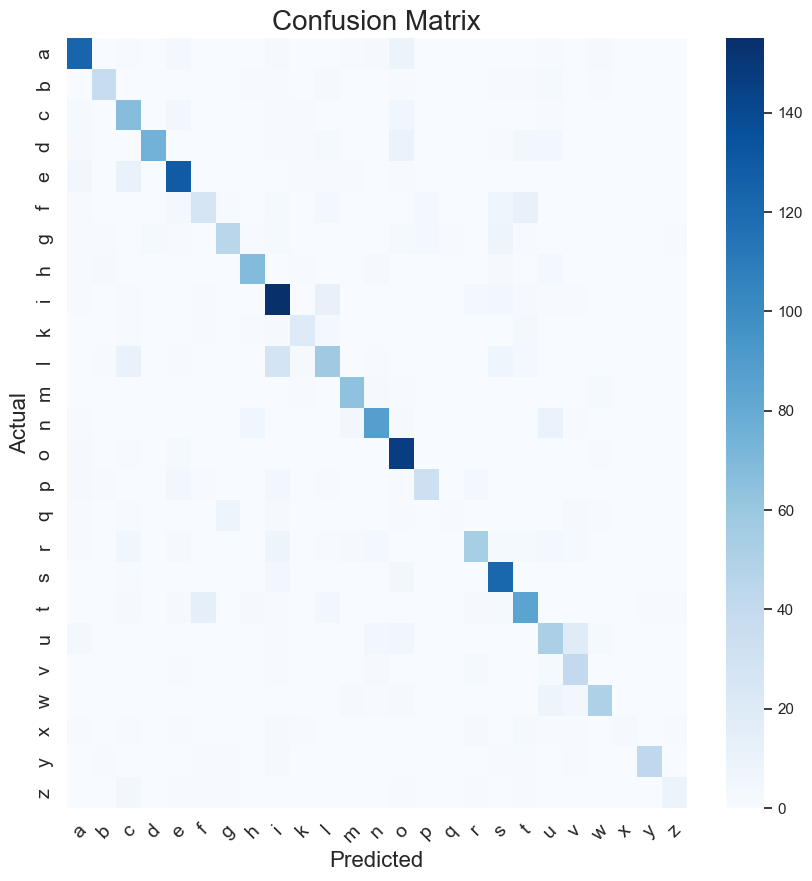

In [19]:
def print_confusion_matrix(conf_matrix, class_names, file_path=None):
    fig, ax = plt.subplots(figsize=(10, 10))  # Aumenta la dimensione della figura
    sns.heatmap(conf_matrix, annot=False, cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual', fontsize=16)
    plt.xlabel('Predicted', fontsize=16)
    plt.title('Confusion Matrix', fontsize=20)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    if file_path:
        plt.savefig(file_path, bbox_inches='tight')  # Usa bbox_inches='tight' per migliorare il layout del salvataggio
    plt.show()

cm = letter_classifier.confusion_matrix(test_loader) 

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

In [20]:
letter_classifier.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')


AUC per la classe a: 0.916
AUC per la classe b: 0.813
AUC per la classe c: 0.743
AUC per la classe d: 0.906
AUC per la classe e: 0.900
AUC per la classe f: 0.493
AUC per la classe g: 0.805
AUC per la classe h: 0.910
AUC per la classe i: 0.847
AUC per la classe k: 0.807
AUC per la classe l: 0.736
AUC per la classe m: 0.919
AUC per la classe n: 0.899
AUC per la classe o: 0.939
AUC per la classe p: 0.791
AUC per la classe q: 0.373
AUC per la classe r: 0.742
AUC per la classe s: 0.939
AUC per la classe t: 0.843
AUC per la classe u: 0.641
AUC per la classe v: 0.677
AUC per la classe w: 0.832
AUC per la classe x: 0.559
AUC per la classe y: 0.960
AUC per la classe z: 0.643


## Comparison with Noted Models in the Literature

In [21]:
from torchvision.models import alexnet, vgg16, googlenet, resnet18, squeezenet1_0, AlexNet_Weights, VGG16_Weights, GoogLeNet_Weights, ResNet18_Weights, SqueezeNet1_0_Weights

class GenericModel(LetterClassifier):

    def __init__(self, model_architecture, num_classes=25):
        super(GenericModel, self).__init__(num_classes=num_classes)
        self.model = self.get_model(model_architecture, num_classes)
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.model.to(self.device)

    def get_model(self, model_architecture, num_classes):
        if model_architecture == 'alexnet':
            model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_architecture == 'vgg':
            model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_architecture == 'googlenet':
            model = googlenet(weights=GoogLeNet_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_architecture == 'resnet':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
        elif model_architecture == 'squeezenet':
            model = squeezenet1_0(weights=SqueezeNet1_0_Weights.DEFAULT)
            model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        else:
            raise ValueError(f"Model architecture '{model_architecture}' not recognized")
        return model

    def extract_features(self, x):
        self.model.eval()
        with torch.no_grad():
            features = self.feature_extractor(x)
            features = features.view(features.size(0), -1)
        return features


## Reload datasets

In [22]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split dataset into training, testing, and validation
train_df = df_train
test_df, val_df = train_test_split(df_test, test_size=0.2, random_state=42)

# Add 'label_int' column to test and validation dataframes
test_df['label_int'] = test_df['label'].apply(lambda x: np.argmax(x))
val_df['label_int'] = val_df['label'].apply(lambda x: np.argmax(x))

train_dataset = CustomDataset(train_df, transform=train_transform, augment=False)
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(test_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## AlexNet

In [23]:
alexnet = GenericModel('alexnet')
print(f'The model has {alexnet.numparams()} trainable parameters')

The model has 57106265 trainable parameters


In [24]:
alexnet.eval()
with torch.no_grad():
    alexnet_test_loss, alexnet_test_accuracy = alexnet.test_model(test_loader)
    
print('\nNon fine-tuned AlexNet:')
print(f'Test Loss: {alexnet_test_loss:.3f}, Test Accuracy: {alexnet_test_accuracy:.3f}')


Non fine-tuned AlexNet:
Test Loss: 3.321, Test Accuracy: 0.039


In [25]:

lr = 0.0001 
momentum = 0.9
weight_decay = 0.01 
exp_name = 'alexnet_experiment'

alexnet_train_losses, alexnet_train_accuracies, alexnet_val_losses, alexnet_val_accuracies = alexnet.train_model(train_loader, 
                                                                                                                 val_loader,
                                                                                                                 exp_name=exp_name, 
                                                                                                                 epochs=20,
                                                                                                                 lr=lr,
                                                                                                                 momentum=momentum,
                                                                                                                 weight_decay=weight_decay)


[Epoch 1/20]
Train Loss: 2.928, Train Accuracy: 0.153 | Val Loss: 2.658, Val Accuracy: 0.232

[Epoch 2/20]


KeyboardInterrupt: 

In [57]:
exp_name = 'alexnet_experiment'
'''
alexnet.eval()

with torch.no_grad():
    alexnet_test_loss, alexnet_test_accuracy = alexnet.test_model(test_loader)

test_error = alexnet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = alexnet_test_loss
metrics['test_accuracy'] = alexnet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")
'''

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
alexnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned AlexNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned AlexNet:
Train Loss: 1.886
Train Accuracy: 0.429

Validation Loss: 1.087
Validation Accuracy: 0.638

Test Loss: 1.104
Test Accuracy: 0.667


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.619
Recall: 0.603
F1 Score: 0.592


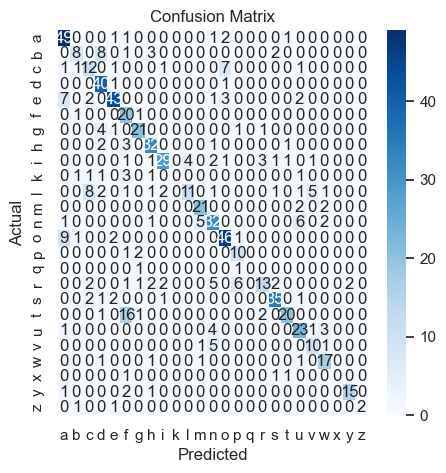

AUC per la classe a: 0.848
AUC per la classe b: 0.645
AUC per la classe c: 0.460
AUC per la classe d: 0.882
AUC per la classe e: 0.833
AUC per la classe f: 0.729
AUC per la classe g: 0.804
AUC per la classe h: 0.833
AUC per la classe i: 0.848
AUC per la classe k: 0.123
AUC per la classe l: 0.488
AUC per la classe m: 0.886
AUC per la classe n: 0.709
AUC per la classe o: 0.870
AUC per la classe p: 0.775
AUC per la classe q: 0.019
AUC per la classe r: 0.572
AUC per la classe s: 0.947
AUC per la classe t: 0.829
AUC per la classe u: 0.709
AUC per la classe v: 0.842
AUC per la classe w: 0.742
AUC per la classe x: 0.400
AUC per la classe y: 0.893
AUC per la classe z: 0.682


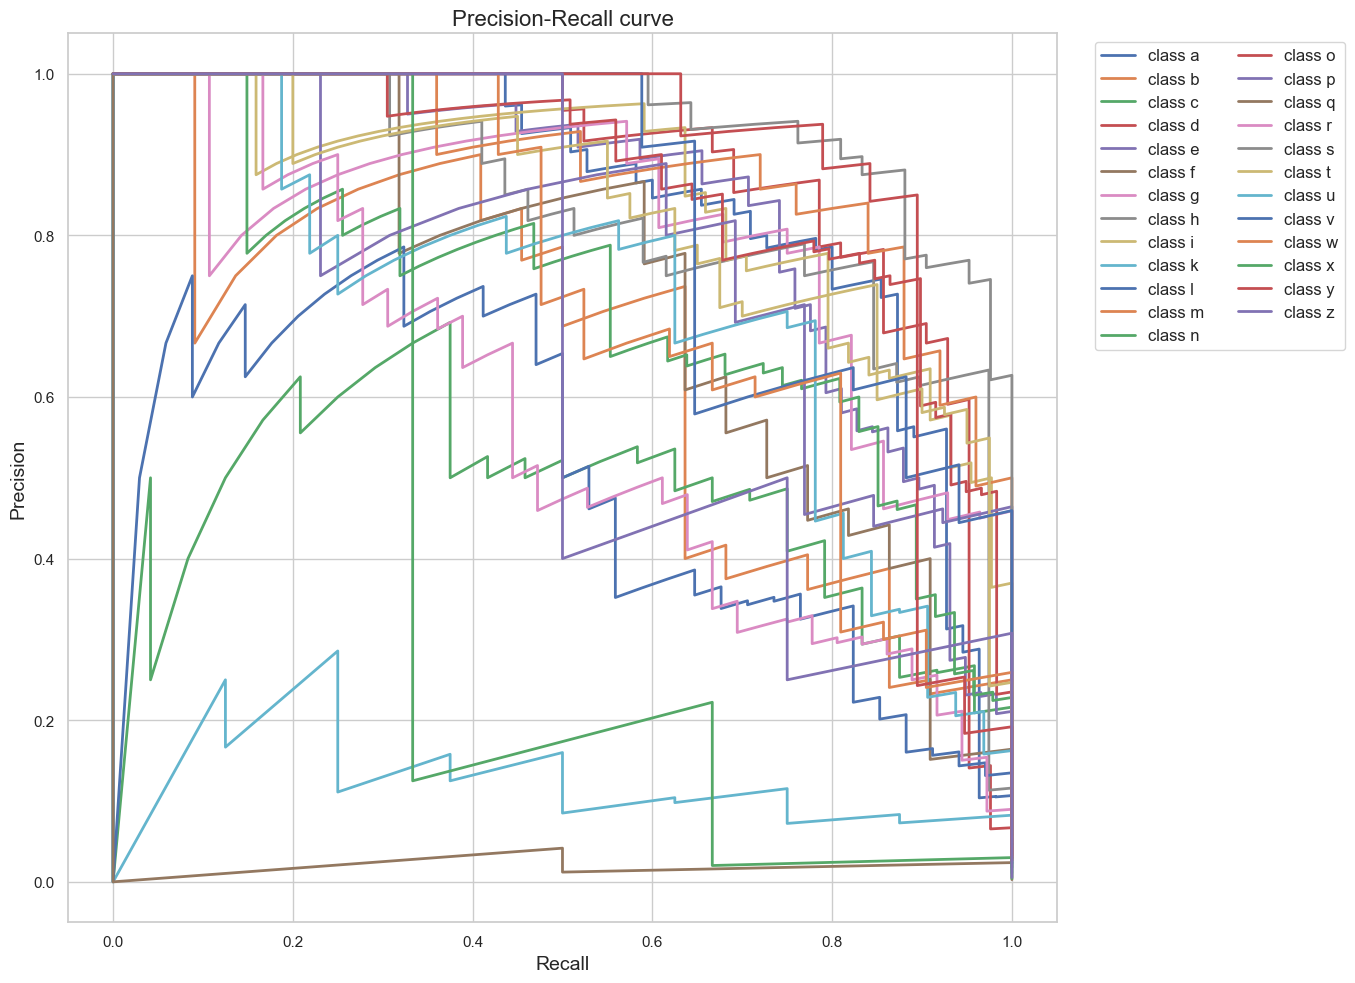

In [ ]:
precision, recall, f1 = alexnet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = alexnet.confusion_matrix(test_loader) 

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

alexnet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

## GoogleNet

In [32]:
googlenet = GenericModel('googlenet')
print(f'The model has {googlenet.numparams()} trainable parameters')

The model has 5625529 trainable parameters


In [33]:
googlenet.eval()
with torch.no_grad():
    googlenet_test_loss, googlenet_test_accuracy = googlenet.test_model(test_loader)
    
print('\nNon fine-tuned GoogleNet:')
print(f'Test Loss: {googlenet_test_loss:.3f}, Test Accuracy: {googlenet_test_accuracy:.3f}')


Non fine-tuned GoogleNet:
Test Loss: 3.274, Test Accuracy: 0.060


In [34]:
exp_name = 'googlenet_experiment'


googlenet_train_losses, googlenet_train_accuracies, googlenet_val_losses, googlenet_val_accuracies = googlenet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=10,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)


[Epoch 1/10]
Train Loss: 3.007, Train Accuracy: 0.120 | Val Loss: 2.864, Val Accuracy: 0.181

[Epoch 2/10]
Train Loss: 2.753, Train Accuracy: 0.220 | Val Loss: 2.571, Val Accuracy: 0.340

[Epoch 3/10]
Train Loss: 2.514, Train Accuracy: 0.289 | Val Loss: 2.245, Val Accuracy: 0.379

[Epoch 4/10]
Train Loss: 2.302, Train Accuracy: 0.350 | Val Loss: 1.943, Val Accuracy: 0.465

[Epoch 5/10]
Train Loss: 2.107, Train Accuracy: 0.397 | Val Loss: 1.663, Val Accuracy: 0.552

[Epoch 6/10]
Train Loss: 1.939, Train Accuracy: 0.443 | Val Loss: 1.436, Val Accuracy: 0.607

[Epoch 7/10]
Train Loss: 1.829, Train Accuracy: 0.474 | Val Loss: 1.267, Val Accuracy: 0.641

[Epoch 8/10]
Train Loss: 1.744, Train Accuracy: 0.498 | Val Loss: 1.128, Val Accuracy: 0.694

[Epoch 9/10]
Train Loss: 1.664, Train Accuracy: 0.518 | Val Loss: 1.005, Val Accuracy: 0.749

[Epoch 10/10]
Train Loss: 1.592, Train Accuracy: 0.539 | Val Loss: 0.915, Val Accuracy: 0.752



In [ ]:
exp_name = 'googlenet_experiment'
googlenet.eval()

with torch.no_grad():
    googlenet_test_loss, googlenet_test_accuracy = googlenet.test_model(test_loader)

test_error = googlenet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = googlenet_test_loss
metrics['test_accuracy'] = googlenet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
googlenet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned GoogleNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned GoogleNet:
Train Loss: 2.946
Train Accuracy: 0.157

Validation Loss: 3.002
Validation Accuracy: 0.122

Test Loss: 2.908
Test Accuracy: 0.141


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.106
Recall: 0.082
F1 Score: 0.070


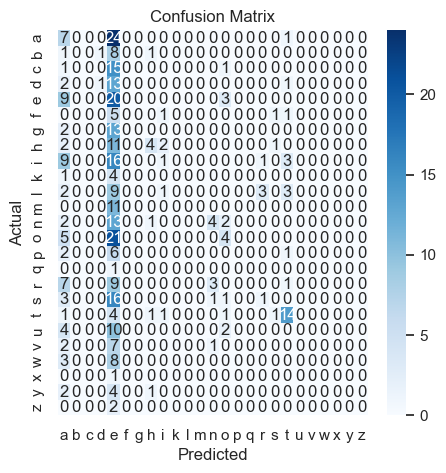

AUC per la classe a: 0.132
AUC per la classe b: 0.077
AUC per la classe c: 0.059
AUC per la classe d: 0.296
AUC per la classe e: 0.178
AUC per la classe f: 0.042
AUC per la classe g: 0.164
AUC per la classe h: 0.143
AUC per la classe i: 0.411
AUC per la classe k: 0.017
AUC per la classe l: 0.182
AUC per la classe m: 0.325
AUC per la classe n: 0.320
AUC per la classe o: 0.228
AUC per la classe p: 0.025
AUC per la classe q: 0.083
AUC per la classe r: 0.124
AUC per la classe s: 0.344
AUC per la classe t: 0.486
AUC per la classe u: 0.053
AUC per la classe v: 0.028
AUC per la classe w: 0.070
AUC per la classe x: 0.012
AUC per la classe y: 0.042
AUC per la classe z: 0.010


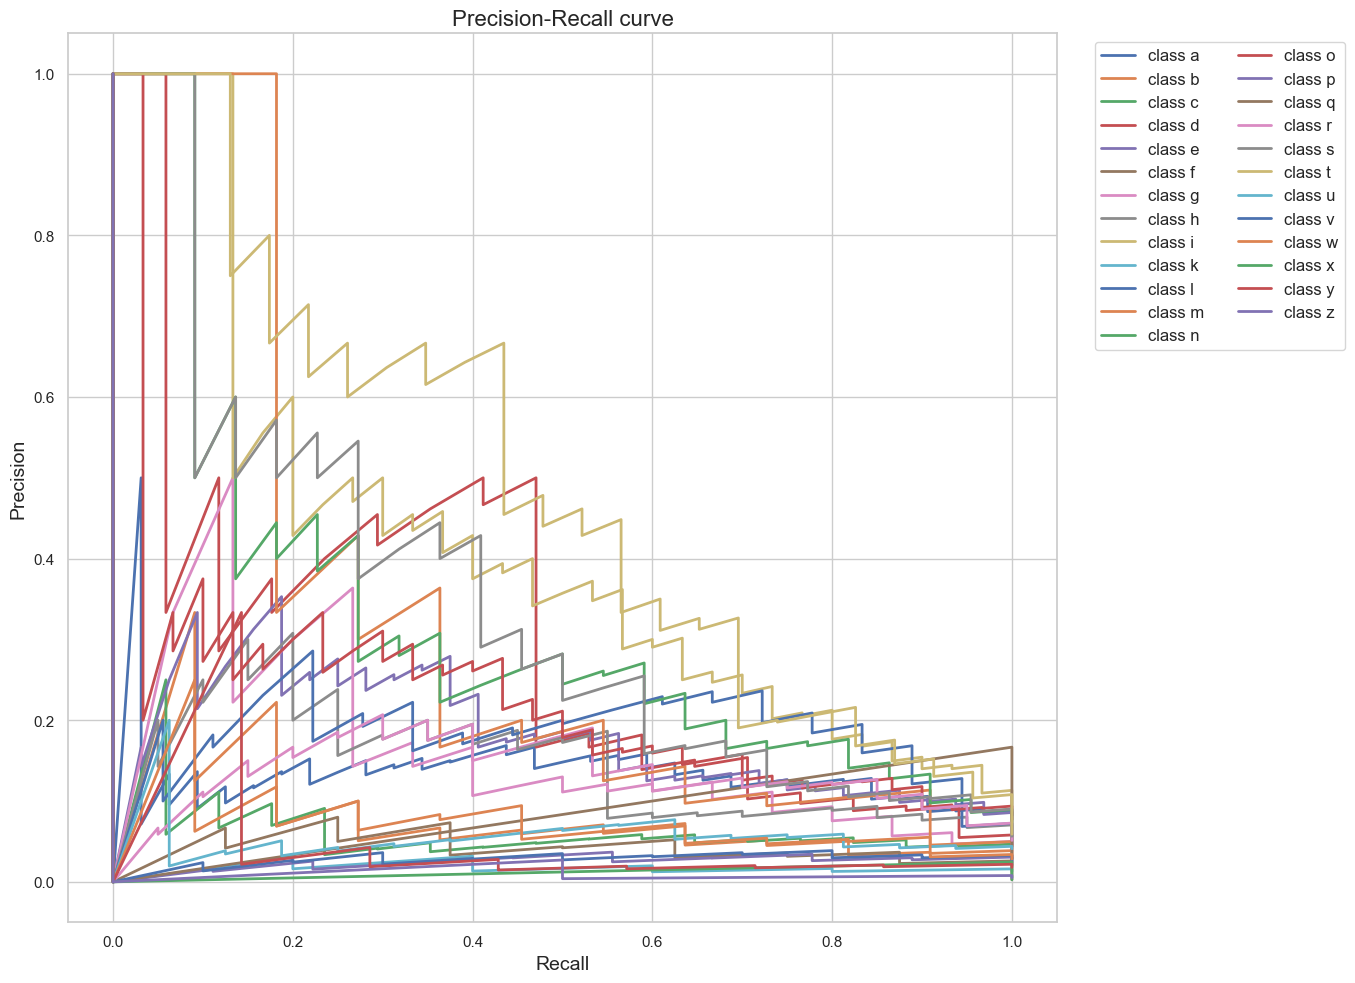

In [ ]:
precision, recall, f1 = googlenet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = googlenet.confusion_matrix(test_loader) 

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

googlenet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')

## ResNet

In [26]:
resnet = GenericModel('resnet')
print(f'The model has {resnet.numparams()} trainable parameters')

The model has 11189337 trainable parameters


In [27]:
resnet.eval()
with torch.no_grad():
    resnet_test_loss, resnet_test_accuracy = resnet.test_model(test_loader)
    
print('\nNon fine-tuned SqueezeNet:')
print(f'Test Loss: {resnet_test_loss:.3f}, Test Accuracy: {resnet_test_accuracy:.3f}')


Non fine-tuned SqueezeNet:
Test Loss: 3.513, Test Accuracy: 0.067


In [28]:

lr = 0.001 
momentum = 0.9
weight_decay = 0.001 
exp_name = 'resnet_experiment2'


resnet_train_losses, resnet_train_accuracies, resnet_val_losses, resnet_val_accuracies = resnet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=30,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)



[Epoch 1/30]
Train Loss: 2.708, Train Accuracy: 0.234 | Val Loss: 2.137, Val Accuracy: 0.340

[Epoch 2/30]
Train Loss: 2.051, Train Accuracy: 0.414 | Val Loss: 1.411, Val Accuracy: 0.598

[Epoch 3/30]
Train Loss: 1.746, Train Accuracy: 0.498 | Val Loss: 1.145, Val Accuracy: 0.653

[Epoch 4/30]
Train Loss: 1.552, Train Accuracy: 0.545 | Val Loss: 0.978, Val Accuracy: 0.700

[Epoch 5/30]
Train Loss: 1.495, Train Accuracy: 0.558 | Val Loss: 0.875, Val Accuracy: 0.740

[Epoch 6/30]
Train Loss: 1.398, Train Accuracy: 0.582 | Val Loss: 0.855, Val Accuracy: 0.709

[Epoch 7/30]
Train Loss: 1.321, Train Accuracy: 0.608 | Val Loss: 0.754, Val Accuracy: 0.751

[Epoch 8/30]
Train Loss: 1.280, Train Accuracy: 0.615 | Val Loss: 0.740, Val Accuracy: 0.762

[Epoch 9/30]
Train Loss: 1.250, Train Accuracy: 0.624 | Val Loss: 0.817, Val Accuracy: 0.728

[Epoch 10/30]
Train Loss: 1.207, Train Accuracy: 0.636 | Val Loss: 0.674, Val Accuracy: 0.762

[Epoch 11/30]
Train Loss: 1.183, Train Accuracy: 0.648 | Va

In [61]:

exp_name = 'resnet_experiment'
resnet.eval()

with torch.no_grad():
    resnet_test_loss, resnet_test_accuracy = resnet.test_model(test_loader)

test_error = resnet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = resnet_test_loss
metrics['test_accuracy'] = resnet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")


Metrics updated and saved successfully


In [62]:
# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
resnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

Model loaded successfully
Metrics loaded successfully



In [63]:
print('Fine-tuned ResNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Fine-tuned ResNet:
Train Loss: 0.991
Train Accuracy: 0.69

Validation Loss: 0.473
Validation Accuracy: 0.838

Test Loss: 0.513
Test Accuracy: 0.843


Precision: 0.814
Recall: 0.784
F1 Score: 0.785


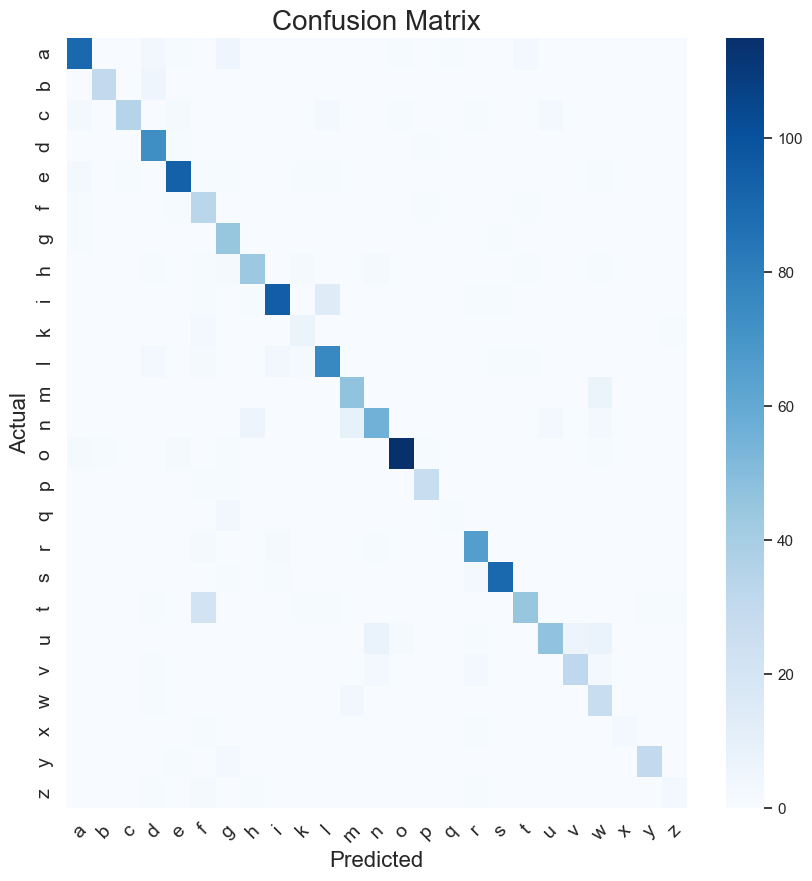

AUC per la classe a: 0.942
AUC per la classe b: 0.992
AUC per la classe c: 0.934
AUC per la classe d: 0.958
AUC per la classe e: 0.933
AUC per la classe f: 0.829
AUC per la classe g: 0.886
AUC per la classe h: 0.908
AUC per la classe i: 0.966
AUC per la classe k: 0.708
AUC per la classe l: 0.883
AUC per la classe m: 0.929
AUC per la classe n: 0.882
AUC per la classe o: 0.983
AUC per la classe p: 0.980
AUC per la classe q: 0.509
AUC per la classe r: 0.935
AUC per la classe s: 0.992
AUC per la classe t: 0.932
AUC per la classe u: 0.894
AUC per la classe v: 0.832
AUC per la classe w: 0.870
AUC per la classe x: 1.000
AUC per la classe y: 0.922
AUC per la classe z: 0.700


In [64]:

precision, recall, f1 = resnet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = resnet.confusion_matrix(test_loader) 

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

resnet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')


<h1>TEST classificazione<h1>

In [65]:
import os
import pickle
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((224,224)),  # ResNet tipicamente usa input di 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image(image_path):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    plt.imshow(image)
    plt.show()
    image = transform(image).unsqueeze(0)  
    return image

def classify_image(image_path, model):
    image = load_image(image_path)
    model.eval()  
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        class_name = class_names[predicted.item()]
        return class_name

model_weights = torch.load(os.path.join('models', 'resnet_experiment.pth'))
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
resnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

image_path = r'C:\Users\orazi\OneDrive\Desktop\Nuova cartella\WhatsApp Image 2024-07-24 at 17.40.34_character_5.png'

class_name = classify_image(image_path, resnet)
print(f'The image is classified as: {class_name}')



Model loaded successfully


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\orazi\\OneDrive\\Desktop\\Nuova cartella\\WhatsApp Image 2024-07-24 at 17.40.34_character_5.png'

In [14]:
import os
import shutil
from PIL import Image
import torch
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image(image_path):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = transform(image).unsqueeze(0)  
    return image

def classify_image(image_path, model):
    image = load_image(image_path)
    model.eval()  
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        class_name = class_names[predicted.item()]
        return class_name, confidence.item()

model_weights = torch.load(os.path.join('models', 'resnet_experiment.pth'))
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
resnet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

def classify_images_in_directory(main_folder, output_folder, model, confidence_threshold=0.8):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    low_confidence_folder = os.path.join(output_folder, 'low_confidence')
    if not os.path.exists(low_confidence_folder):
        os.makedirs(low_confidence_folder)
    
    for subdir, _, files in os.walk(main_folder):
        for file in files:
            image_path = os.path.join(subdir, file)
            if image_path.endswith(('.jpg')):
                class_name, confidence = classify_image(image_path, model)
                if confidence < confidence_threshold:
                    dest_folder = low_confidence_folder
                else:
                    dest_folder = os.path.join(output_folder, class_name)
                if not os.path.exists(dest_folder):
                    os.makedirs(dest_folder)
                shutil.copy(image_path, os.path.join(dest_folder, file))


main_folder = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\dati4'

output_folder = r'C:\Users\orazi\OneDrive\Desktop\tesi\datiT\classificate2.0'

classify_images_in_directory(main_folder, output_folder, resnet)


Model loaded successfully


<h1>Estrazione Vettori Feature<h1>

In [22]:
from torchvision.transforms import transforms
import json


df['subject'] = df.apply(lambda row: row['subject'], axis=1)

letters = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']
num_to_letter = {i: letter for i, letter in enumerate(letters)}

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(dataframe['label_int'].unique())}
        if self.augment:
            self.dataframe = pd.concat([dataframe, dataframe]).reset_index(drop=True)
        else:
            self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_array = row['image']
        if len(image_array.shape) == 3 and image_array.shape[2] == 1:
            image_array = image_array.squeeze(-1)  
        image = Image.fromarray(image_array.astype(np.uint8)).convert('RGB')  
        label = row['label_int']
        subject = row['subject']  

        if self.transform:
            image = self.transform(image)

        return image, label, subject  

def collate_fn(batch):
    images, labels, subjects = zip(*batch)
    return torch.stack(images), torch.tensor(labels), subjects

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    subjects = []
    with torch.no_grad():
        for batch in dataloader:
            inputs, lbls, subs = batch
            inputs = inputs.to(model.device)
            feats = model.extract_features(inputs)
            features.extend(feats.cpu().numpy())
            labels.extend(lbls.numpy())
            subjects.extend(subs)
    return np.array(features), np.array(labels), np.array(subjects)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

train_features, train_labels, train_subjects = extract_features(resnet, train_loader)
test_features, test_labels, test_subjects = extract_features(resnet, test_loader)

def save_features(features, labels, subjects, filename):
    data = []
    for feature, label, subject in zip(features, labels, subjects):
        letter = num_to_letter[label]
        data.append({
            'subject': subject,
            'letter': letter,
            'features': json.dumps(feature.tolist())  
        })
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

save_features(train_features, train_labels, train_subjects, 'featureVectors/train_features.csv')
save_features(test_features, test_labels, test_subjects, 'featureVectors/test_features.csv')


print("I vettori delle caratteristiche sono stati salvati nei file CSV.")


I vettori delle caratteristiche sono stati salvati nei file CSV.


<h1>Distanza Euclidea e di Manhattan<h1>

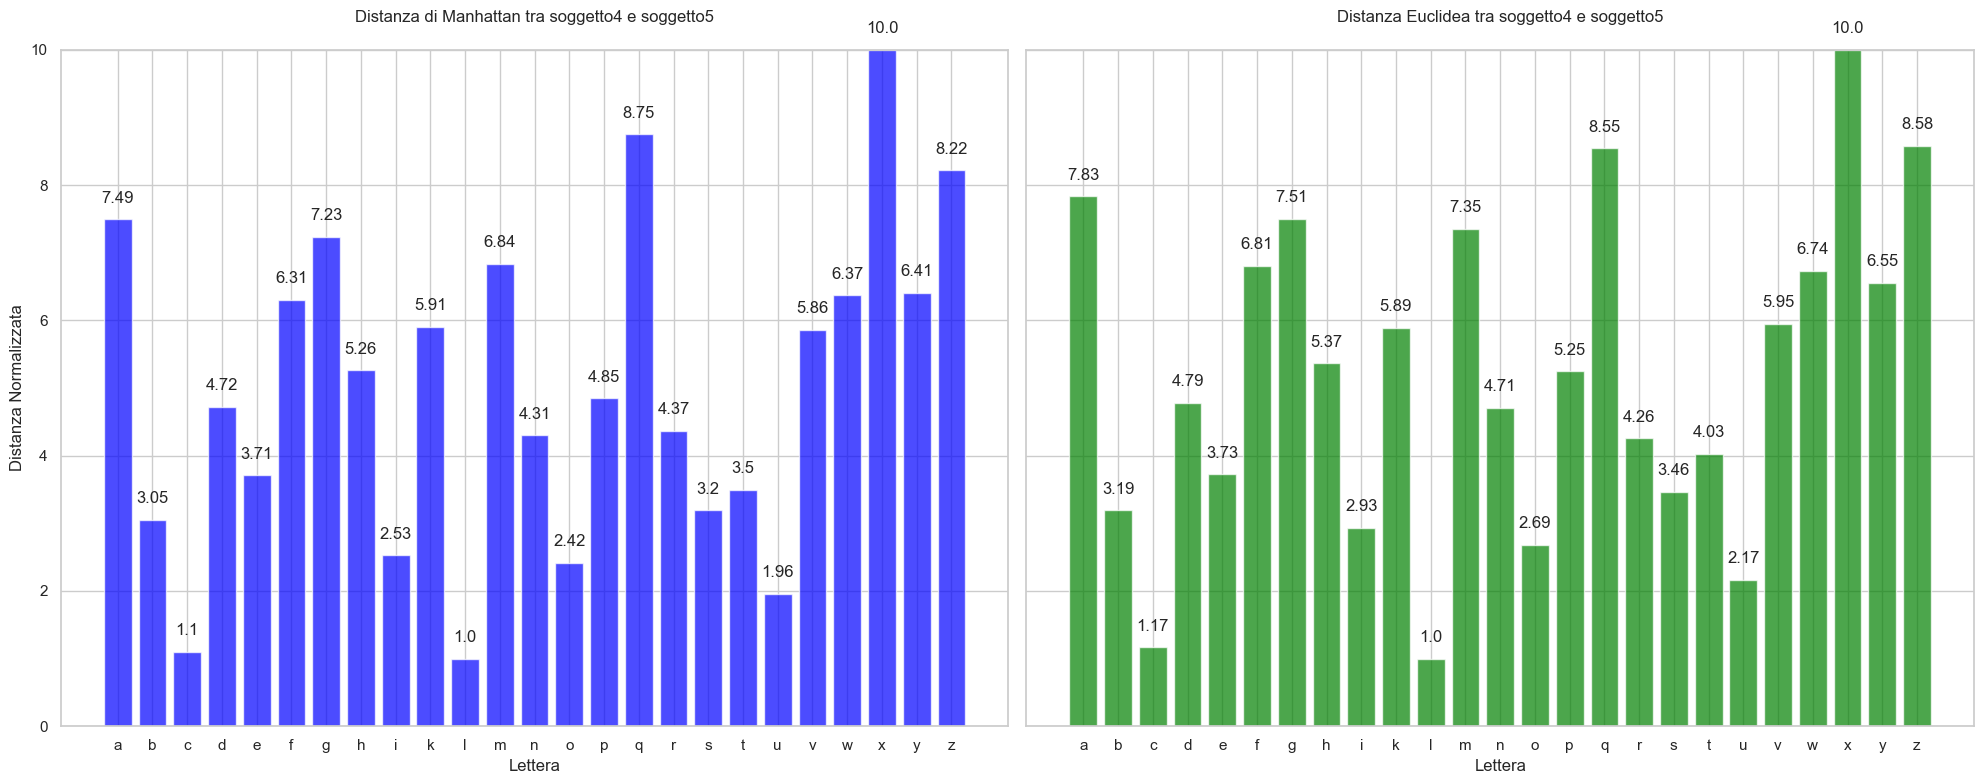

La differenza media di stile tra soggetto4 e soggetto5 su una scala da 1 a 10 con la distanza di Manhattan è: 5.01
La differenza media di stile tra soggetto4 e soggetto5 su una scala da 1 a 10 con la distanza Euclidea è: 5.22


In [77]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean, cityblock
import matplotlib.pyplot as plt

train_features_df = pd.read_csv('featureVectors/train_features.csv')

train_features_df['features'] = train_features_df['features'].apply(eval)

letters = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']
num_to_letter = {i: letter for i, letter in enumerate(letters)}

# Funzione per calcolare le distanze tra le caratteristiche di due soggetti specifici per ogni lettera
def calculate_distances_between_subjects(features_df, subject1, subject2, distance_metric):
    if subject1 == subject2:
        print(f"I soggetti sono gli stessi: {subject1}")
        return [0] * len(letters)  # Ritorna una lista di zeri
    
    distances = []
    
    for letter in letters:
        subject1_features = features_df[(features_df['subject'] == subject1) & (features_df['letter'] == letter)]['features']
        subject2_features = features_df[(features_df['subject'] == subject2) & (features_df['letter'] == letter)]['features']
        
        if not subject1_features.empty and not subject2_features.empty:
            subject1_mean = np.mean(np.vstack(subject1_features), axis=0)
            subject2_mean = np.mean(np.vstack(subject2_features), axis=0)
            
            distance = distance_metric(subject1_mean, subject2_mean)
            distances.append(distance)
    
    return distances

# Funzione per normalizzare le distanze su una scala da 1 a 10
def normalize_distances(distances):
    if all(d == 0 for d in distances):
        return [1] * len(distances)  
    
    min_distance = min(distances)
    max_distance = max(distances)
    
    normalized_distances = [((distance - min_distance) / (max_distance - min_distance)) * 9 + 1 for distance in distances]
    
    return normalized_distances

subject1 = 'soggetto4'
subject2 = 'soggetto5'

manhattan_distances = calculate_distances_between_subjects(train_features_df, subject1, subject2, cityblock)

euclidean_distances = calculate_distances_between_subjects(train_features_df, subject1, subject2, euclidean)

normalized_manhattan_distances = normalize_distances(manhattan_distances)
normalized_euclidean_distances = normalize_distances(euclidean_distances)

def plot_normalized_distances(letters, manhattan_distances, euclidean_distances):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

    # Grafico per la distanza di Manhattan
    ax1.bar(letters, manhattan_distances, color='blue', alpha=0.7)
    ax1.set_xlabel('Lettera')
    ax1.set_ylabel('Distanza Normalizzata')
    ax1.set_title(f'Distanza di Manhattan tra {subject1} e {subject2}', pad=20)
    ax1.set_ylim(0, 10)
    ax1.grid(True)
    for i, val in enumerate(manhattan_distances):
        ax1.text(i, val + 0.2, round(val, 2), ha='center', va='bottom')  

    # Grafico per la distanza Euclidea
    ax2.bar(letters, euclidean_distances, color='green', alpha=0.7)
    ax2.set_xlabel('Lettera')
    ax2.set_title(f'Distanza Euclidea tra {subject1} e {subject2}', pad=20)
    ax2.set_ylim(0, 10)
    ax2.grid(True)
    for i, val in enumerate(euclidean_distances):
        ax2.text(i, val + 0.2, round(val, 2), ha='center', va='bottom')  

    plt.tight_layout()
    plt.show()

plot_normalized_distances(letters, normalized_manhattan_distances, normalized_euclidean_distances)

# Calcola la media delle distanze normalizzate come una singola misura di differenza di stile
average_manhattan_difference = np.mean(normalized_manhattan_distances)
average_euclidean_difference = np.mean(normalized_euclidean_distances)

print(f"La differenza media di stile tra {subject1} e {subject2} su una scala da 1 a 10 con la distanza di Manhattan è: {average_manhattan_difference:.2f}")
print(f"La differenza media di stile tra {subject1} e {subject2} su una scala da 1 a 10 con la distanza Euclidea è: {average_euclidean_difference:.2f}")


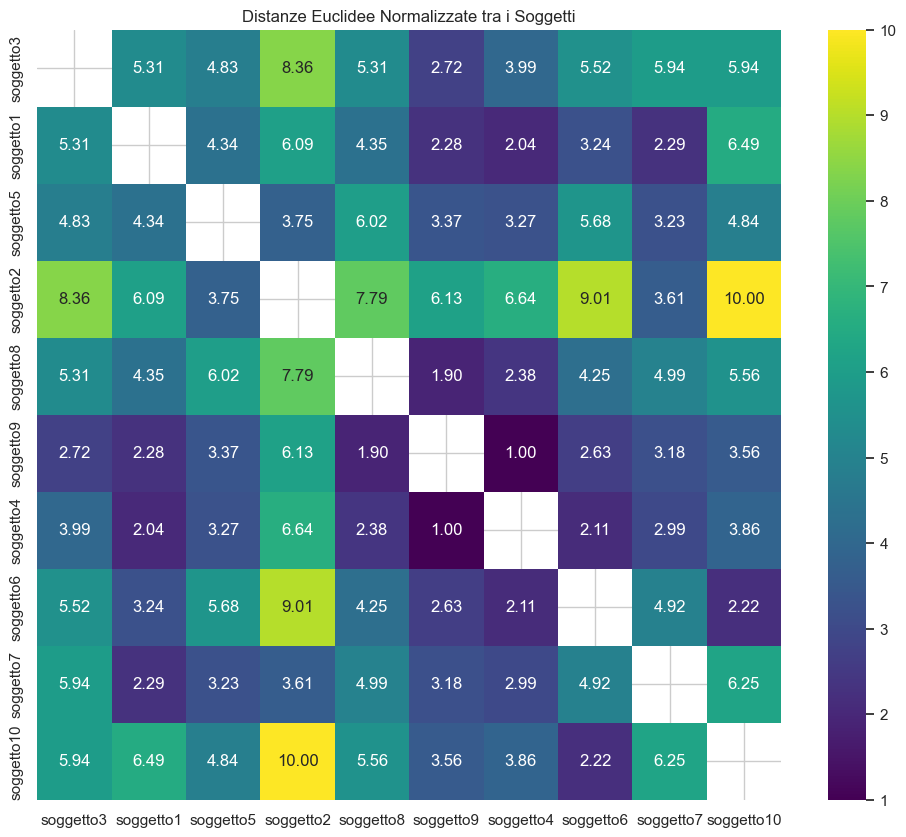

In [82]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
import json

train_features_df = pd.read_csv('featureVectors/train_features.csv')

train_features_df['features'] = train_features_df['features'].apply(json.loads)

letters = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']
num_to_letter = {i: letter for i, letter in enumerate(letters)}

# Funzione per calcolare le distanze tra le caratteristiche di due soggetti specifici per ogni lettera
def calculate_distances_between_subjects(features_df, subject1, subject2, distance_metric):
    distances = []
    
    for letter in letters:
        subject1_features = features_df[(features_df['subject'] == subject1) & (features_df['letter'] == letter)]['features'].apply(np.array)
        subject2_features = features_df[(features_df['subject'] == subject2) & (features_df['letter'] == letter)]['features'].apply(np.array)
        
        if not subject1_features.empty and not subject2_features.empty:
            subject1_mean = np.mean(np.vstack(subject1_features), axis=0)
            subject2_mean = np.mean(np.vstack(subject2_features), axis=0)
            
            distance = distance_metric(subject1_mean, subject2_mean)
            distances.append(distance)
    
    return distances

# Funzione per calcolare le distanze tra tutti i soggetti
def calculate_all_subject_distances(features_df, distance_metric):
    subjects = features_df['subject'].unique()
    distances = pd.DataFrame(index=subjects, columns=subjects)
    
    for i, subject1 in enumerate(subjects):
        for subject2 in subjects[i+1:]:
            subject_distances = calculate_distances_between_subjects(features_df, subject1, subject2, distance_metric)
            avg_distance = np.mean(subject_distances)
            distances.loc[subject1, subject2] = avg_distance
            distances.loc[subject2, subject1] = avg_distance
    
    return distances

# Funzione per normalizzare le distanze su una scala da 1 a 10
def normalize_distances(distances):
    min_distance = distances.min().min()
    max_distance = distances.max().max()
    
    normalized_distances = distances.map(lambda x: ((x - min_distance) / (max_distance - min_distance)) * 9 + 1)
    
    return normalized_distances

# Calcola le distanze tra tutti i soggetti utilizzando la distanza euclidea
subject_distances = calculate_all_subject_distances(train_features_df, euclidean)

# Normalizza le distanze
normalized_subject_distances = normalize_distances(subject_distances)

# Visualizza le distanze tra i soggetti utilizzando una heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(normalized_subject_distances, annot=True, cmap='viridis', fmt='.2f')
plt.title('Distanze Euclidee Normalizzate tra i Soggetti')
plt.show()


In [31]:
import torch
import random
import numpy as np

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

NUM_EPOCHS=50

In [32]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, UnidentifiedImageError
import torchvision.transforms as transforms

class PairDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        # Collect all image paths and labels
        self.image_paths = []
        self.labels = []

        # Create a mapping from folder names to labels
        self.label_mapping = {label: idx for idx, label in enumerate("abcdefghiklmnopqrstuvwxyz")}
        
        for subject in os.listdir(root):
            subject_path = os.path.join(root, subject)
            if os.path.isdir(subject_path):
                for label in os.listdir(subject_path):
                    if label in self.label_mapping:  # only process valid labels
                        label_path = os.path.join(subject_path, label)
                        if os.path.isdir(label_path):
                            for image_name in os.listdir(label_path):
                                image_path = os.path.join(label_path, image_name)
                                # Check if the file is a valid image
                                try:
                                    Image.open(image_path).verify()
                                    self.image_paths.append(image_path)
                                    self.labels.append(self.label_mapping[label])
                                except (IOError, UnidentifiedImageError):
                                    print(f"Skipping non-image file: {image_path}")

        self.labels = np.array(self.labels)
        
        # Create a list of indices for each class
        self.class_to_indices = [np.where(self.labels == idx)[0] for idx in range(len(self.label_mapping))]
        
        # Generate pairs
        self.generate_pairs()

    def generate_pairs(self):
        """Generates pairs, associating each element with a new element."""
        self.pair_labels = (np.random.rand(len(self.image_paths)) > 0.5).astype(int)
        self.paired_idx = []

        for i, l in enumerate(self.pair_labels):
            c1 = self.labels[i]
            if l == 0:  # similar pair
                j = np.random.choice(self.class_to_indices[c1])
            else:  # dissimilar pair
                diff_class = np.random.choice(list(set(range(len(self.label_mapping))) - {c1}))
                j = np.random.choice(self.class_to_indices[diff_class])
            self.paired_idx.append(j)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        im1_path = self.image_paths[i]
        im2_path = self.image_paths[self.paired_idx[i]]
        
        im1 = Image.open(im1_path).convert('L')
        im2 = Image.open(im2_path).convert('L')

        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
        
        l = self.pair_labels[i]
        l1 = self.labels[i]
        l2 = self.labels[self.paired_idx[i]]

        return im1, im2, l, l1, l2

Skipping non-image file: dataset\soggetto10\k\k_desktop.ini
Skipping non-image file: dataset\soggetto10\q\q_desktop.ini
Skipping non-image file: dataset\soggetto10\v\v_desktop.ini
Skipping non-image file: dataset\soggetto10\x\x_desktop.ini
Skipping non-image file: dataset\soggetto10\z\z_desktop.ini
Skipping non-image file: dataset\soggetto11\b\b_desktop.ini
Skipping non-image file: dataset\soggetto11\d\d_desktop.ini
Skipping non-image file: dataset\soggetto11\f\f_desktop.ini
Skipping non-image file: dataset\soggetto11\k\k_desktop.ini
Skipping non-image file: dataset\soggetto11\w\w_desktop.ini
Skipping non-image file: dataset\soggetto11\y\y_desktop.ini
Skipping non-image file: dataset\soggetto12\k\k_desktop.ini
Skipping non-image file: dataset\soggetto12\q\q_desktop.ini
Skipping non-image file: dataset\soggetto13\k\k_desktop.ini
Skipping non-image file: dataset\soggetto13\q\q_desktop.ini
Skipping non-image file: dataset\soggetto13\x\x_desktop.ini
Skipping non-image file: dataset\soggett

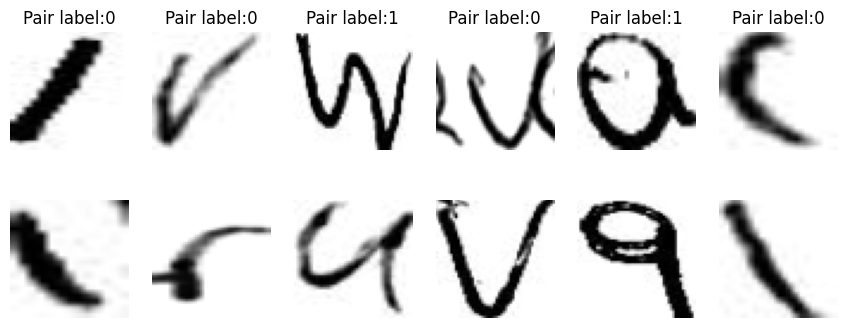

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Assuming PairDataset is already defined and implemented
pair_dataset = PairDataset(root='dataset', transform=transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor()
]))

# Displaying the pairs of images
plt.figure(figsize=(18, 4))
for ii, i in enumerate(np.random.choice(range(len(pair_dataset)), 6)):
    plt.subplot(2, 10, ii + 1)
    plt.title('Pair label:' + str(pair_dataset[i][2]))
    plt.imshow(pair_dataset[i][0].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 10, ii + 11)
    plt.imshow(pair_dataset[i][1].squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

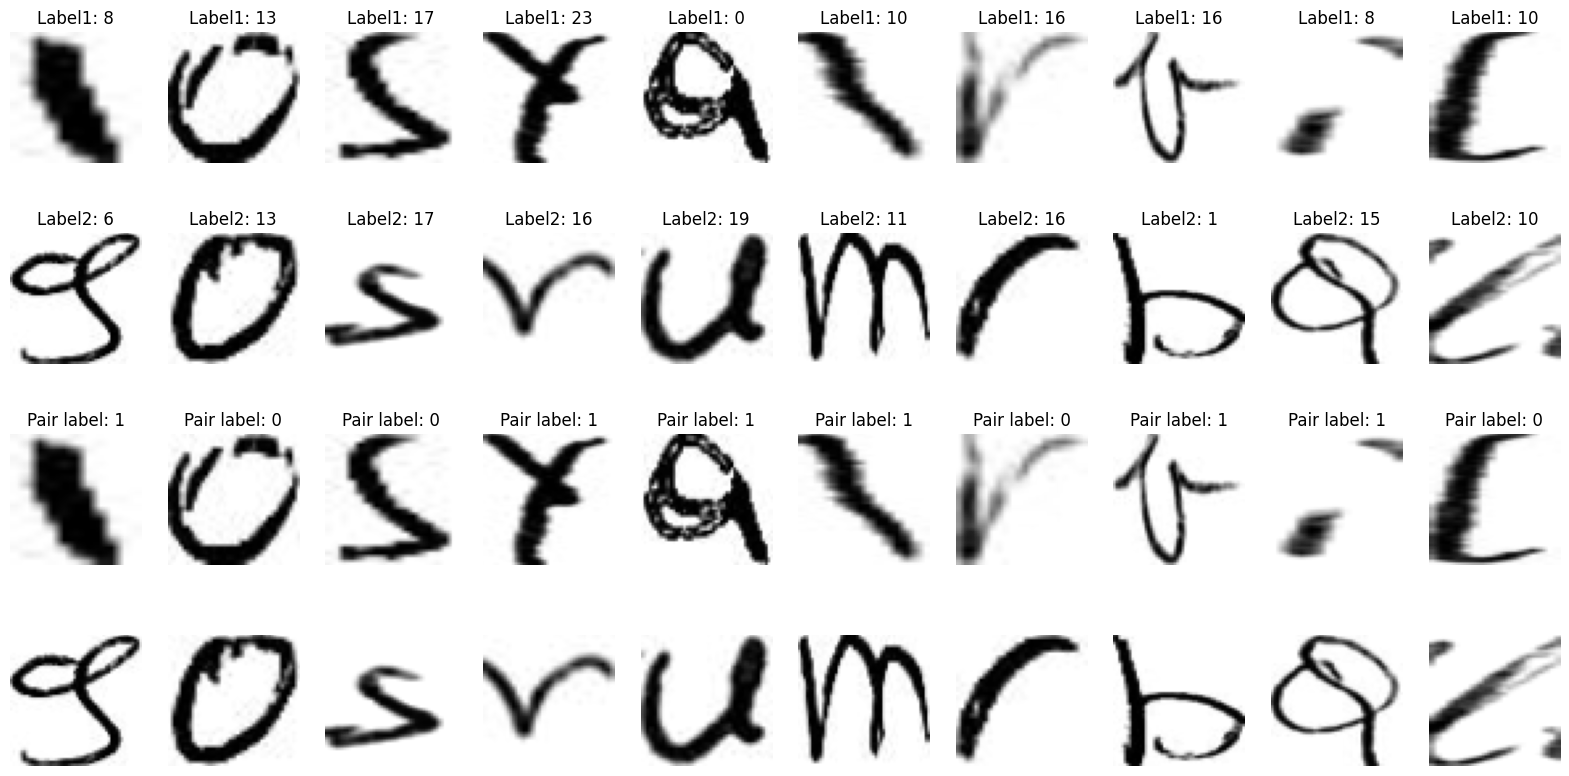

In [34]:
# Function to verify labels
def verify_labels(dataset, num_samples=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        im1, im2, pair_label, label1, label2 = dataset[idx]

        plt.subplot(4, num_samples, i + 1)
        plt.title(f'Label1: {label1}')
        plt.imshow(im1.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + num_samples)
        plt.title(f'Label2: {label2}')
        plt.imshow(im2.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
        plt.title(f'Pair label: {pair_label}')
        plt.imshow(im1.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
        plt.imshow(im2.squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show()

# Verify labels
verify_labels(pair_dataset, num_samples=10)

In [35]:
from torch import nn
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.BatchNorm2d(32),
                                     nn.Conv2d(32, 64, 5), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.BatchNorm1d(64 *4 * 4),
                                nn.Linear(64 * 4 * 4, 256),
                                nn.ReLU(),
                                nn.BatchNorm1d(256),
                                nn.Linear(256, 128))

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

In [36]:
model = EmbeddingNet()
model(torch.zeros(16,1,28,28)).shape

torch.Size([16, 128])

In [37]:
from torch.nn import functional as F

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, m=2):
        super(ContrastiveLoss, self).__init__()
        self.m = m

    def forward(self, phi_i, phi_j, l_ij):
        d = F.pairwise_distance(phi_i, phi_j)
        l = 0.5 * (1 - l_ij.float()) * torch.pow(d,2) + \
            0.5 * l_ij.float() * torch.pow( torch.clamp( self.m - d, min = 0) , 2)
        return l.mean()

In [38]:
import pytorch_lightning as pl
import itertools
from torch.utils.data import DataLoader
import torchvision
from torch.optim import SGD

class SiameseNetworkTask(pl.LightningModule):
    def __init__(self, 
                 embedding_net, # la rete di embedding
                 lr=0.01, # il learning rate
                 momentum=0.99, # momentum
                 margin=2 # margine per la loss
                ):
        super(SiameseNetworkTask, self).__init__()
        self.save_hyperparameters()
        self.embedding_net = embedding_net
        self.criterion = ContrastiveLoss(margin) #definiamo la loss
                    
    def forward(self, x):
        return self.model(x)
        
    def configure_optimizers(self):
        return SGD(self.embedding_net.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
    
    def training_step(self, batch, batch_idx):
        # preleviamo gli elementi I_i e I_j e l'etichetta l_ij
        # scartiamo il resto (le etichette dei singoli elementi)
        I_i, I_j, l_ij, *_ = batch
        
        #l'implementazione della rete siamese è banale:
        #eseguiamo la embedding net sui due input
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)

        #calcoliamo la loss
        l = self.criterion(phi_i, phi_j, l_ij)
        
        self.log('train/loss', l)
        return l
    
    def validation_step(self, batch, batch_idx):
        I_i, I_j, l_ij, *_ = batch
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)
        l = self.criterion(phi_i, phi_j, l_ij)
        self.log('valid/loss', l)
        
        if batch_idx==0:
            self.logger.experiment.add_embedding(phi_i, batch[3], I_i, global_step=self.global_step)

In [41]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Ensure all images are 28x28
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full dataset
full_dataset = PairDataset(root='dataset', transform=transform)

# Split the dataset into 80% training and 20% testing
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024)

Skipping non-image file: dataset\soggetto10\k\k_desktop.ini
Skipping non-image file: dataset\soggetto10\q\q_desktop.ini
Skipping non-image file: dataset\soggetto10\v\v_desktop.ini
Skipping non-image file: dataset\soggetto10\x\x_desktop.ini
Skipping non-image file: dataset\soggetto10\z\z_desktop.ini
Skipping non-image file: dataset\soggetto11\b\b_desktop.ini
Skipping non-image file: dataset\soggetto11\d\d_desktop.ini
Skipping non-image file: dataset\soggetto11\f\f_desktop.ini
Skipping non-image file: dataset\soggetto11\k\k_desktop.ini
Skipping non-image file: dataset\soggetto11\w\w_desktop.ini
Skipping non-image file: dataset\soggetto11\y\y_desktop.ini
Skipping non-image file: dataset\soggetto12\k\k_desktop.ini
Skipping non-image file: dataset\soggetto12\q\q_desktop.ini
Skipping non-image file: dataset\soggetto13\k\k_desktop.ini
Skipping non-image file: dataset\soggetto13\q\q_desktop.ini
Skipping non-image file: dataset\soggetto13\x\x_desktop.ini
Skipping non-image file: dataset\soggett

In [42]:
from pytorch_lightning.loggers import TensorBoardLogger

siamese_mnist_task = SiameseNetworkTask(EmbeddingNet())
logger = TensorBoardLogger("logs", name="siamese_mnist")
trainer = pl.Trainer( logger=logger, max_epochs=NUM_EPOCHS, enable_progress_bar=False)

trainer.fit(siamese_mnist_task, train_loader, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type            | Params | Mode 
----------------------------------------------------------
0 | embedding_net | EmbeddingNet    | 350 K  | train
1 | criterion     | ContrastiveLoss | 0      | train
----------------------------------------------------------
350 K     Trainable params
0         Non-trainable params
350 K     Total params
1.400     Total estimated model params size (MB)
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (10) is smaller than th

In [50]:
# Salvataggio del modello

torch.save(siamese_mnist_task.state_dict(), 'models/siamese_experiment.pth')

In [51]:
model = SiameseNetworkTask(EmbeddingNet())
model.load_state_dict(torch.load('models/siamese_experiment.pth'))

<All keys matched successfully>

## SqueezeNet

In [ ]:
squeezenet = GenericModel('squeezenet')
print(f'The model has {squeezenet.numparams()} trainable parameters')

The model has 748249 trainable parameters


In [ ]:
squeezenet.eval()
with torch.no_grad():
    squeezenet_test_loss, squeezenet_test_accuracy = squeezenet.test_model(test_loader)
    
print('\nNon fine-tuned SqueezeNet:')
print(f'Test Loss: {squeezenet_test_loss:.3f}, Test Accuracy: {squeezenet_test_accuracy:.3f}')


Non fine-tuned SqueezeNet:
Test Loss: 3.715, Test Accuracy: 0.039


In [ ]:
'''
lr = 0.001 
momentum = 0.9
weight_decay = 0.001 
exp_name = 'squeezenet_experiment'


squeezenet_train_losses, squeezenet_train_accuracies, squeezenet_val_losses, squeezenet_val_accuracies = squeezenet.train_model(train_loader, 
                                                                                             val_loader,
                                                                                             exp_name=exp_name, 
                                                                                             epochs=20,
                                                                                             lr=lr,
                                                                                             momentum=momentum,
                                                                                             weight_decay=weight_decay)
'''

[Epoch 1/20]
Train Loss: 3.095, Train Accuracy: 0.084 | Val Loss: 3.052, Val Accuracy: 0.076

[Epoch 2/20]
Train Loss: 2.827, Train Accuracy: 0.160 | Val Loss: 2.438, Val Accuracy: 0.232

[Epoch 3/20]
Train Loss: 2.607, Train Accuracy: 0.215 | Val Loss: 2.188, Val Accuracy: 0.308

[Epoch 4/20]
Train Loss: 2.473, Train Accuracy: 0.256 | Val Loss: 1.872, Val Accuracy: 0.438

[Epoch 5/20]
Train Loss: 2.291, Train Accuracy: 0.321 | Val Loss: 1.729, Val Accuracy: 0.486

[Epoch 6/20]
Train Loss: 2.193, Train Accuracy: 0.344 | Val Loss: 1.742, Val Accuracy: 0.449

[Epoch 7/20]
Train Loss: 2.113, Train Accuracy: 0.382 | Val Loss: 1.647, Val Accuracy: 0.503

[Epoch 8/20]
Train Loss: 2.027, Train Accuracy: 0.403 | Val Loss: 1.468, Val Accuracy: 0.519

[Epoch 9/20]
Train Loss: 1.952, Train Accuracy: 0.414 | Val Loss: 1.345, Val Accuracy: 0.600

[Epoch 10/20]
Train Loss: 1.888, Train Accuracy: 0.437 | Val Loss: 1.408, Val Accuracy: 0.557

[Epoch 11/20]
Train Loss: 1.875, Train Accuracy: 0.438 | Va

In [ ]:
exp_name = 'squeezenet_experiment'
squeezenet.eval()

with torch.no_grad():
    squeezenet_test_loss, squeezenet_test_accuracy = squeezenet.test_model(test_loader)

test_error = squeezenet.test_error(test_loader)

# Carica i metrics
metrics_file_path = os.path.join('metrics', f'{exp_name}_metrics.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Aggiorna i metrics con i valori più recenti
metrics['test_loss'] = squeezenet_test_loss
metrics['test_accuracy'] = squeezenet_test_accuracy
metrics['test_error'] = test_error

# Salva i metrics aggiornati
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

# Carica i pesi del modello
model_weights_path = os.path.join('models', f'{exp_name}.pth')
model_weights = torch.load(model_weights_path)
model_weights = {'model.' + k if not k.startswith('model.') else k: v for k, v in model_weights.items()}
squeezenet.load_state_dict(model_weights, strict=False)
print("Model loaded successfully")

# Ricarica i metrics
with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

print('Fine-tuned SqueezeNet:')

# Assicurati che i valori delle metriche siano numeri singoli
train_loss = metrics['train_loss'] if isinstance(metrics['train_loss'], (int, float)) else metrics['train_loss'][-1]
train_accuracy = metrics['train_accuracy'] if isinstance(metrics['train_accuracy'], (int, float)) else metrics['train_accuracy'][-1]
val_loss = metrics['val_loss'] if isinstance(metrics['val_loss'], (int, float)) else metrics['val_loss'][-1]
val_accuracy = metrics['val_accuracy'] if isinstance(metrics['val_accuracy'], (int, float)) else metrics['val_accuracy'][-1]
test_loss = metrics['test_loss'] if isinstance(metrics['test_loss'], (int, float)) else metrics['test_loss'][-1]
test_accuracy = metrics['test_accuracy'] if isinstance(metrics['test_accuracy'], (int, float)) else metrics['test_accuracy'][-1]

print(f"Train Loss: {round(float(train_loss), 3)}")
print(f"Train Accuracy: {round(float(train_accuracy), 3)}\n")
print(f"Validation Loss: {round(float(val_loss), 3)}")
print(f"Validation Accuracy: {round(float(val_accuracy), 3)}\n")
print(f"Test Loss: {round(float(test_loss), 3)}")
print(f"Test Accuracy: {round(float(test_accuracy), 3)}")

Metrics updated and saved successfully
Model loaded successfully
Metrics loaded successfully

Fine-tuned SqueezeNet:
Train Loss: 1.875
Train Accuracy: 0.438

Validation Loss: 1.029
Validation Accuracy: 0.676

Test Loss: 1.085
Test Accuracy: 0.681


C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.658
Recall: 0.594
F1 Score: 0.594


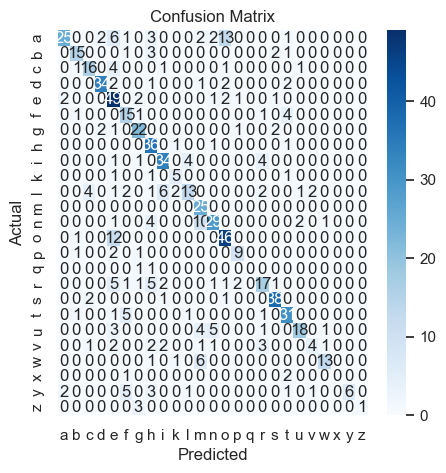

AUC per la classe a: 0.748
AUC per la classe b: 0.604
AUC per la classe c: 0.805
AUC per la classe d: 0.908
AUC per la classe e: 0.792
AUC per la classe f: 0.603
AUC per la classe g: 0.904
AUC per la classe h: 0.853
AUC per la classe i: 0.800
AUC per la classe k: 0.541
AUC per la classe l: 0.644
AUC per la classe m: 0.949
AUC per la classe n: 0.793
AUC per la classe o: 0.821
AUC per la classe p: 0.643
AUC per la classe q: 0.006
AUC per la classe r: 0.593
AUC per la classe s: 0.975
AUC per la classe t: 0.791
AUC per la classe u: 0.762
AUC per la classe v: 0.661
AUC per la classe w: 0.748
AUC per la classe x: 0.006
AUC per la classe y: 0.740
AUC per la classe z: 0.771


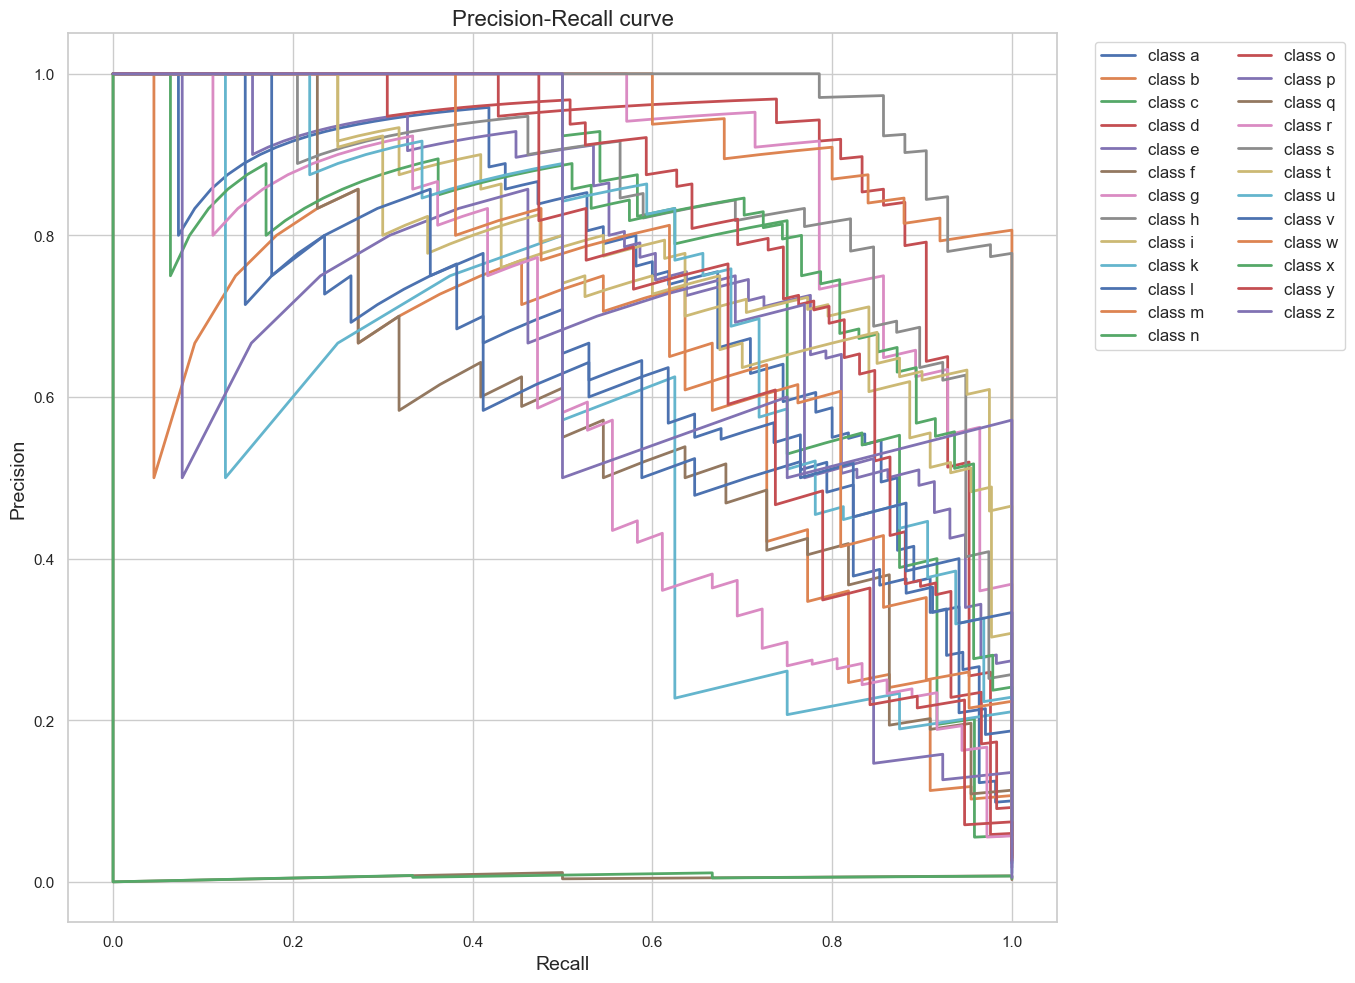

In [ ]:
precision, recall, f1 = squeezenet.evaluate(test_loader)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

cm = squeezenet.confusion_matrix(test_loader) 
class_names = [chr(i) for i in range(ord('a'), ord('z') + 1) if chr(i) != 'j']  

print_confusion_matrix(cm, class_names, f'plots/{exp_name}_confusion_matrix.png')

squeezenet.plot_precision_recall_curve(test_loader, f'plots/{exp_name}_prec_rec_curve.png')